# MIR Project: melody segmentation
Prepared by Philip Tovstogan

This project evaluates the performance of two melody segmentation algorithms:

### Local Boundary Detection Model (LBDM) by Cambouropoulos ([MATLAB code](https://github.com/miditoolbox/1.1/blob/master/miditoolbox/boundary.m))

*Cambouropoulos, E. (1997). Musical rhythm: A formal model for determining local boundaries, accents and metre in a melodic surface. In M. Leman (Ed.), Music, Gestalt, and Computing: Studies in Cognitive and Systematic Musicology (pp. 277-293). Berlin: Springer Verlag.*


### Segmentation algorithm by Tenney & Polansky ([MATLAB code](https://github.com/miditoolbox/1.1/blob/master/miditoolbox/segmentgestalt.m))

*Tenney, J.  & Polansky, L. (1980). Temporal gestalt perception in music. Journal of Music Theory, 24(2), 205–41.*

The dataset that is used for evaluation is [SymbTr](https://github.com/MTG/makam-symbolic-phrase-segmentation) that is a collection of Turkish Makam music with ground-truth annotations for phrase boundaries.

In [1]:
import music21 as m21
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
def lbdm(midi_data):
    """Implementing LBDM as in Miditoolbox (boundary.m)"""
    note_midi = np.array([note.pitch.midi for note in midi_data.recurse().notes])
    pitch_profile = np.abs(note_midi[1:] - note_midi[:-1])  # Miditoolbox variable 'pp'
    
    onsets = []  # Miditoolbox variable 'on'
    offsets_org = []
    durations = []
    
#     for bar in midi_data[0]:
    for note in midi_data.recurse().notes:
        if type(note) is m21.note.Note:  # avoid data without duration, not a note event
            onsets.append(note.offset)
            durations.append(note.duration.quarterLength)
            offsets_org.append(note.offset)
    
    onsets = np.array(onsets)
    durations = np.array(durations)
    offsets = onsets + durations  # Miditoolbox variable 'off'

    ioi_profile = onsets[1:] - onsets[:-1]  # Miditoolbox variable 'po'
    rest_profile = onsets[1:] - offsets[:-1]  # Miditoolbox variable 'pr'
    rest_profile = (rest_profile + np.abs(rest_profile)) / 2  # half wave rect. (max(0,x) in Miditoolbox)

    # degrees of change [see boundary.m]
    rp = np.abs(pitch_profile[1:] - pitch_profile[:-1]) / (0.000001 + pitch_profile[1:] + pitch_profile[:-1])
    rp = np.append(rp,0)
    ro = [np.abs(ioi_profile[1:] - ioi_profile[:-1]) / (0.000001 + ioi_profile[1:] + ioi_profile[:-1])]
    ro = np.append(ro,0)
    rr = [np.abs(rest_profile[1:] - rest_profile[:-1]) / (0.000001 + rest_profile[1:] + rest_profile[:-1])]
    rr = np.append(rr,0)

    # strengths
    sp = pitch_profile * np.append(0, rp[:-1] + rp[1:])
    if np.max(sp) > 0.1:
        sp = sp / np.max(sp)

    so = ioi_profile*np.append(0, ro[:-1] + ro[1:])
    if np.max(so) > 0.1:
        so = so / np.max(so)

    sr = rest_profile * np.append(0, rr[:-1] + rr[1:])
    if np.max(sr) > 0.1:
        sr = sr / np.max(sr)

    # overall profile
    return np.append(1, 0.25*sp + 0.5*so + 0.25*sr), durations

In [21]:
test_filename = 'hicaz--sarki--aksak--su_karsiki--dede_efendi'
# test_filename = 'hicaz--sarki--aksak--su_karsiki_dagda--dede_efendi'
midi_data = m21.converter.parse('midi/{}.mid'.format(test_filename))

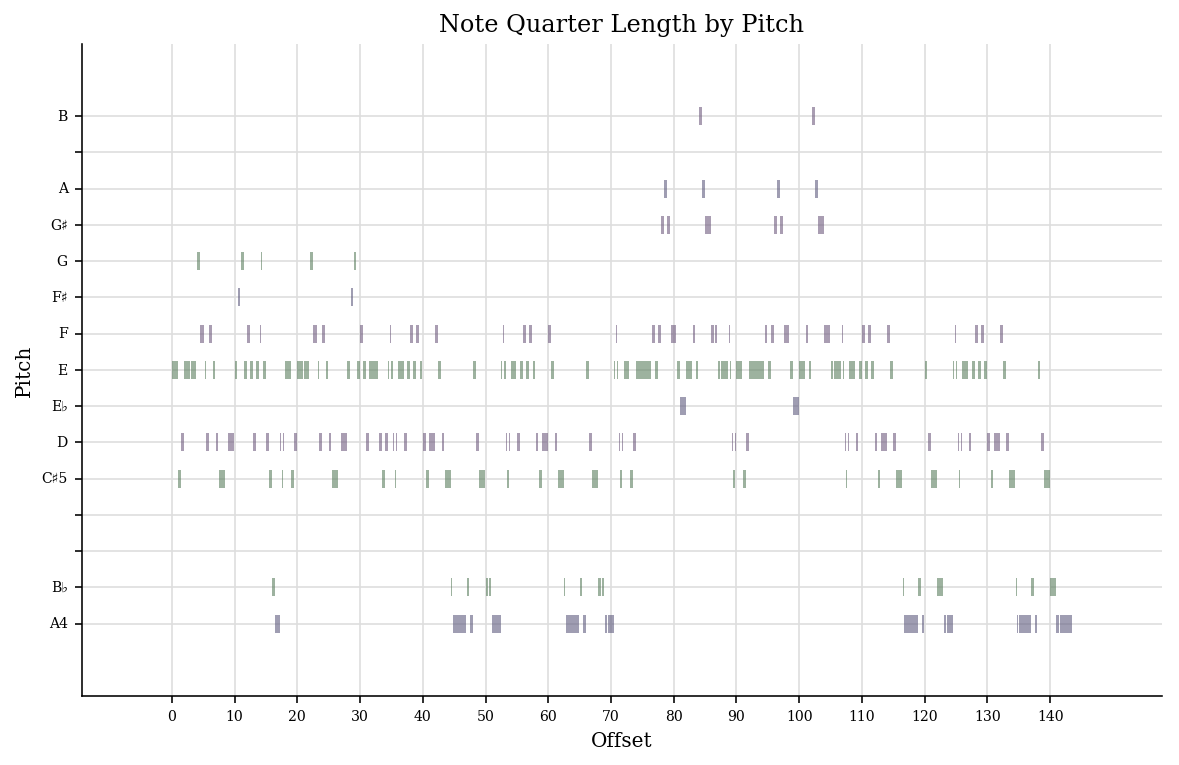

In [33]:
# test_data = midi_data.measures(1, 4)
test_data = midi_data
test_data.plot()

In [38]:
profile, durations = lbdm(test_data)

Text(0.5,0,'Time in quarter lengths')

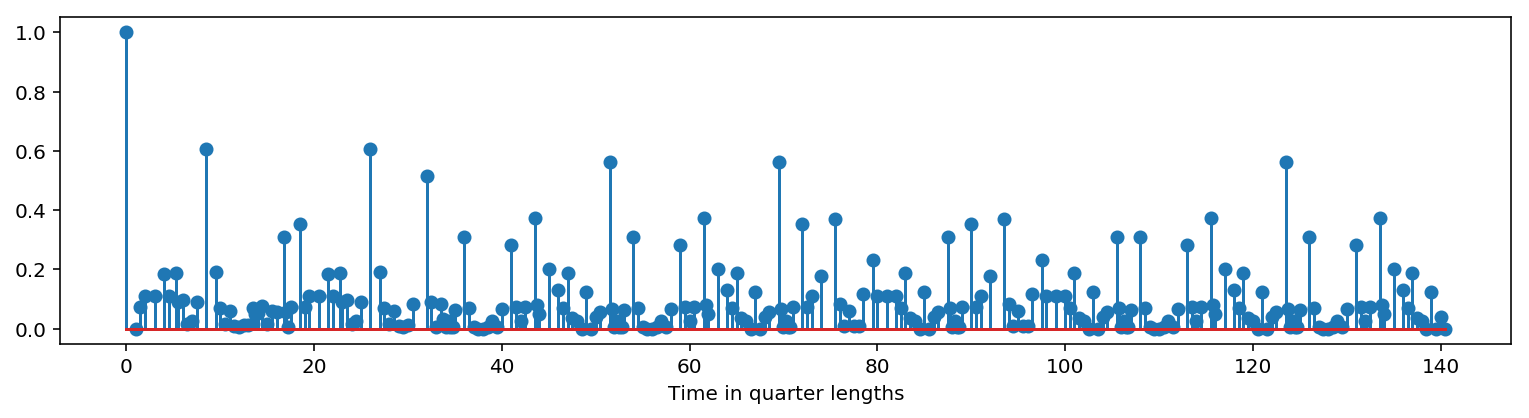

In [40]:
plt.figure(figsize=(13, 3))
plt.stem(np.cumsum(np.append(0, durations[:-1])), profile)
plt.xlabel('Time in quarter lengths')

In [43]:
len(profile)

255